# **FINAL CLUSTERING**

In [2]:
#MAIN LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#CLUSTERING
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#INTERNAL VALIDATION METRICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

#CLUSTERING VISUALIZATIONS
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

pd.options.display.float_format = '{:.1f}'.format #So the numbers will not appear in a scientific format




## SUBCLUSTERING

- I´m gonna apply a new clustering over the general clusters to define subclusters and make a better grouping

- For this new clustering I am going to use 3 variables: FORMAT LOADS, IMPRESSIONS AND CLICKS. These are the 3 more important variables that I didn´t use in the first clustering. I chose not to use them because the scale is extremely higher that the scale of the percentage variables, although I also tried with Standar and Robust Scalers, so I hope these variables will give me some interesting clusters, after this first general division. 

In [3]:
clusters = pd.read_csv('DATA/Main Clusters before subclustering.csv')
groupby_domains = pd.read_csv('DATA/Groupby Domains.csv')


subclustering = groupby_domains[['Format Loads', 'Impressions', 'Clicks']].copy()
subclustering['Cluster'] = clusters['Cluster']

<AxesSubplot:>

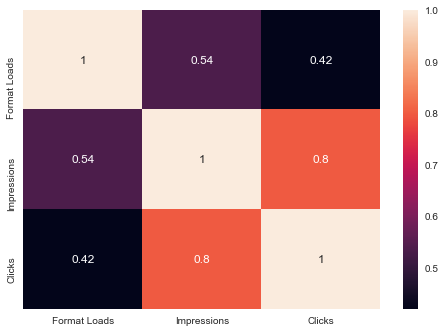

In [4]:
sns.heatmap(subclustering.drop('Cluster', 1).corr(), annot=True)

**PCA is a way to deal with highly correlated variables, so there is no need to remove them**


Text(0, 0.5, 'Cumulative explained variance')

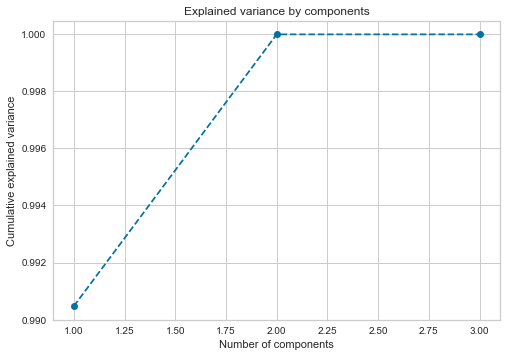

In [5]:
pca = PCA()
pca.fit(subclustering.drop('Cluster', 1))
plt.plot(range(1,4), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

<AxesSubplot:>

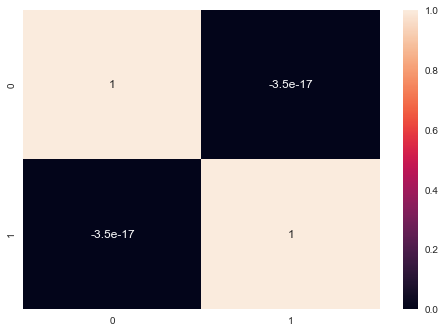

In [6]:
# I choose 2 components to be able to plot the results
pca=PCA(n_components=2)
new_clustering_pca = pd.DataFrame(pca.fit_transform(subclustering.drop('Cluster', 1)))
display(sns.heatmap(new_clustering_pca.corr(), annot=True))
new_clustering_pca['Cluster'] = clusters['Cluster']

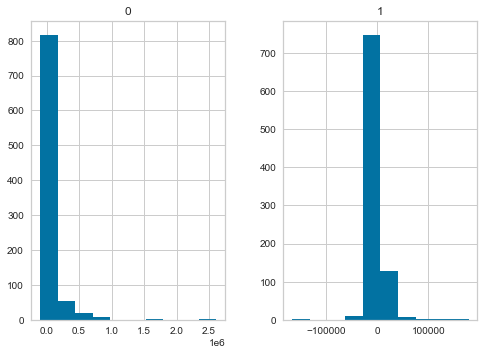

In [9]:
new_clustering_pca.drop('Cluster', 1).hist();

- **NOTE : I did the subclustering proccess applying MinMax Scaler and Robust Scaler, but the results and the quality of the clusters were practically identical to the subclustering without preprocessing**

In [10]:
def visualization_clusters(data, clustering_model):

    # calinski_harabasz, silhouette scores and distortion visualization
    visualizer1 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='calinski_harabasz', timings=False
    )

    visualizer1.fit(data)        # Fit the data to the visualizer
    visualizer1.show()        # Finalize and render the figure

    visualizer2 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='silhouette', timings=False
    )

    visualizer2.fit(data)       
    visualizer2.show()       
    
    visualizer3 = KElbowVisualizer(
    clustering_model, k=(3,17), metric='distortion', timings=False
    )

    visualizer3.fit(data)        
    visualizer3.show()        

- I have to modify the results_evaluation function so it works with the shape of each cluster:

In [11]:

def results_evaluation_subclusters(model, data, cluster_number):

  

    print('CLUSTERING DIVISION:\n', pd.DataFrame(model.labels_)[0].value_counts())
    
    new_df = subclustering[subclustering['Cluster']==cluster_number].copy()
    new_df['Cluster'] = model.labels_
    display(new_df.groupby('Cluster').mean())
    
    print('The Silhouette Score is: ', silhouette_score(data, model.labels_, metric='euclidean'))
    print('The Calinski Harabasz Score is: ', calinski_harabasz_score(data, model.labels_))
    print('The Davies Douldin Score is: ', davies_bouldin_score(data, model.labels_))


### ***SUBCLUSTERING: CLUSTER 1***

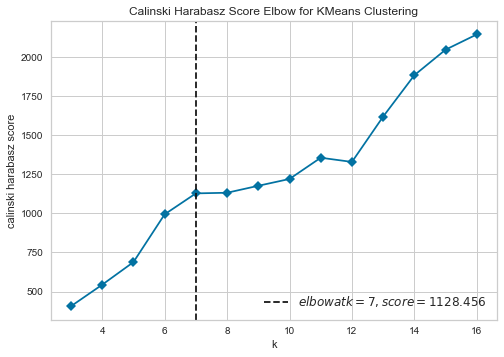

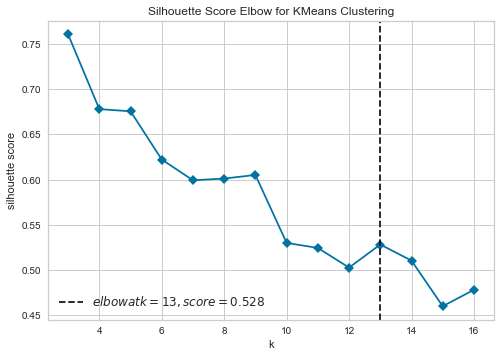

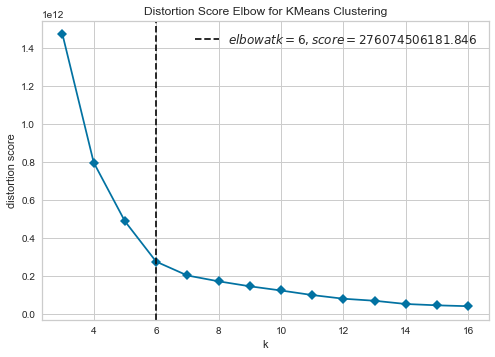

In [13]:
cluster1= new_clustering_pca[new_clustering_pca['Cluster']==1].copy()
cluster1.drop('Cluster', 1, inplace=True)
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(cluster1, model)

CLUSTERING DIVISION:
 0    96
4    47
2    16
5     8
1     4
3     1
Name: 0, dtype: int64


,Format Loads,Impressions,Clicks
Cluster,,,
0,43021.6,5381.1,24.7
1,935071.7,77104.9,459.9
2,318721.9,28079.1,196.7
3,1732798.1,124798.8,98.4
4,136565.3,8579.5,53.3
5,609388.5,28897.5,287.7


The Silhouette Score is:  0.6231921017970445
The Calinski Harabasz Score is:  990.6614268740533
The Davies Douldin Score is:  0.4311874455852638


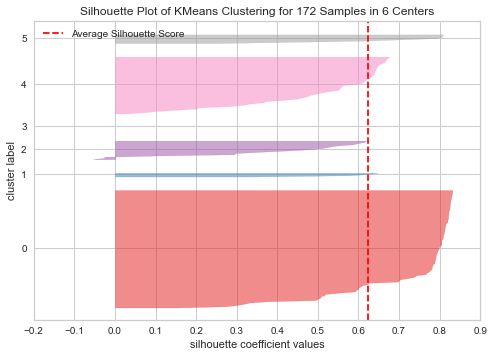

<AxesSubplot:xlabel='0', ylabel='1'>

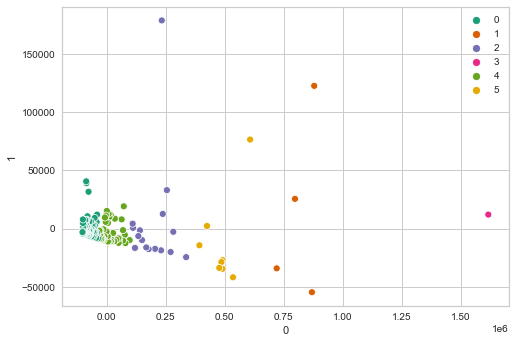

In [17]:
kmeans_cluster1 = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_cluster1.fit(cluster1)
results_evaluation_subclusters(kmeans_cluster1, cluster1, 1)

sv = SilhouetteVisualizer(kmeans_cluster1)
sv.fit(cluster1)
sv.show()

sns.scatterplot(cluster1[0], cluster1[1], hue=kmeans_cluster1.labels_,palette='Dark2')

In [18]:
pd.options.display.max_columns=None

subclusters1 = subclustering[subclustering['Cluster']==1].copy()
subclusters1['Subcluster'] = kmeans_cluster1.labels_
subclusters1 = subclusters1.merge(groupby_domains[['Format Fill Rate']], left_index=True, right_index=True)
sub1_1, sub1_2 , sub1_3, sub1_4, sub1_5, sub1_6 = [x for _, x in subclusters1.groupby('Subcluster')] #To make easier the analysis below
subclusters1.drop('Cluster', 1).groupby('Subcluster').describe()


Format Loads                                                  \
                  count      mean     std       min       25%       50%   
Subcluster                                                                
0                  96.0   43021.6 18067.6   20050.7   27570.5   39441.0   
1                   4.0  935071.7 71554.7  842081.3  897176.4  953058.8   
2                  16.0  318721.9 68340.0  231418.1  261071.8  313756.6   
3                   1.0 1732798.1     nan 1732798.1 1732798.1 1732798.1   
4                  47.0  136565.3 34442.7   91104.3  109248.5  127656.7   
5                   8.0  609388.5 63729.4  514596.9  586064.8  610559.5   

                               Impressions                                     \
                 75%       max       count     mean     std      min      25%   
Subcluster                                                                      
0            53209.2   85713.2        96.0   5381.1  8041.8      4.0   1183.7   
1           990954.1  992088.0         4.0  77104.9 81457.0  11080.8  19364.3   
2           362058.4  459106.4        16.0  28079.1 49244.4   1771.5   6564.6   
3          1732798.1 1732798.1         1.0 124798.8     nan 124798.8 124798.8   
4           159745.7  219605.0        47.0   8579.5  8659.4     23.0   1924.3   
5           624564.2  722822.4         8.0  28897.5 40679.4   2777.2   7261.1   

                                      Clicks                               \
                50%      75%      max  count  mean   std  min   25%   50%   
Subcluster                                                                  
0            2402.4   6053.5  45797.9   96.0  24.7  39.0  0.0   4.4  12.1   
1           54363.8 112104.3 188611.0    4.0 459.9 580.1 48.5 122.6 239.5   
2           11590.4  22896.2 203967.2   16.0 196.7 351.1 18.5  59.6  89.4   
3          124798.8 124798.8 124798.8    1.0  98.4   nan 98.4  98.4  98.4   
4            5468.1  12002.2  34416.3   47.0  53.3  72.2  0.1   9.9  27.1   
5           13697.8  25889.9 125441.9    8.0 287.7 566.0  4.4  39.2  69.7   

                        Format Fill Rate                                      
             75%    max            count mean  std  min  25%  50%  75%   max  
Subcluster                                                                    
0           24.9  221.2             96.0 11.6 15.4  0.0  2.8  6.8 15.5 112.3  
1          576.8 1312.0              4.0 10.0  8.6  1.1  3.6  9.7 16.0  19.5  
2          148.0 1460.7             16.0 12.3 16.1  0.3  1.9  7.8 13.7  63.2  
3           98.4   98.4              1.0 10.8  nan 10.8 10.8 10.8 10.8  10.8  
4           66.3  311.4             47.0  7.4  7.8  0.0  1.6  4.5 12.4  32.5  
5          162.2 1667.4              8.0  6.2  7.6  0.4  1.9  3.0  6.4  21.8

- **Cluster 1 subcluster 1**:Main subcluster with 96 domains and the lowest Format Loads of the cluster, between 20.000 and 85.000. The means of Impressions and clicks are also very poor, 5300 and and 24
- **Cluster 1 subcluster 2**: 4 outliers with Format loads range 840-992.000, and high rates of Impressions and means. Format Fill Rate mean is 10%
- **Cluster 1 subcluster 3**: 16 Domains. Format Loads between 230.000 and 460.000. Best format fill rate of the cluster
- **Cluster 1 subcluster 4**:The second main Domain of the dataset(1.700.000 Format Loads, 10,81% Format Fill Rate)
- **Cluster 1 subcluster 5**: 47 Domains. Format load range(136.000-219.000). Clicks and impressions are widespread, low mean of Format Fill Rate(7%)
- **Cluster 1 subcluster 6**: 6  domains with Format loads range 514-722.000, the mean of clicks is the highest of the cluster, but with the lowest Format Fill Rate mean of the cluster, 6%



### ***SUBCLUSTERING: CLUSTER 2***

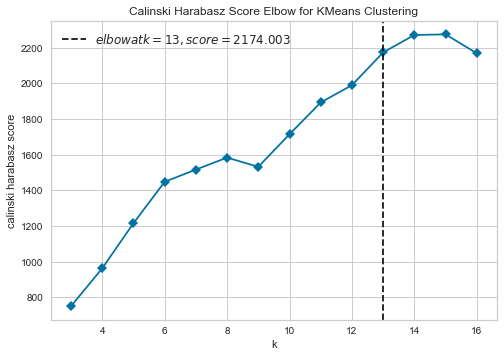

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


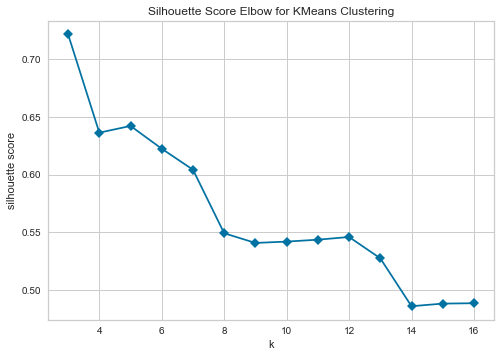

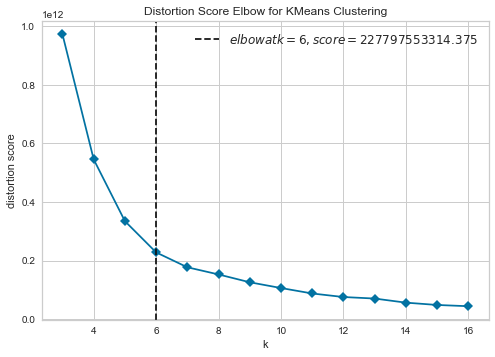

In [22]:
cluster2= new_clustering_pca[new_clustering_pca['Cluster']==2].copy()
cluster2.drop('Cluster', 1, inplace=True)
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(cluster2, model)

CLUSTERING DIVISION:
 2    155
1     75
5     27
0     18
4      8
3      3
Name: 0, dtype: int64


,Format Loads,Impressions,Clicks
Cluster,,,
0,372570.7,26566.0,168.4
1,112699.3,11617.5,83.9
2,41168.2,3983.7,28.5
3,874187.9,174513.9,1526.8
4,585542.4,46270.2,339.6
5,212409.0,20670.1,142.0


The Silhouette Score is:  0.6223599679584927
The Calinski Harabasz Score is:  1448.0771573236877
The Davies Douldin Score is:  0.5101775259579893


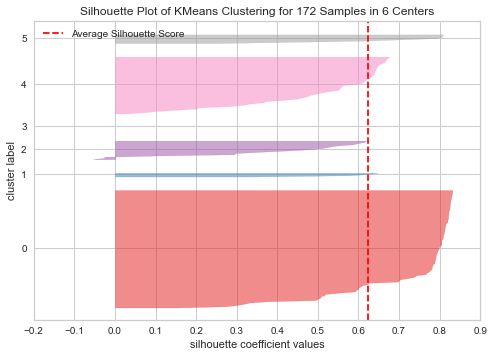

<AxesSubplot:xlabel='0', ylabel='1'>

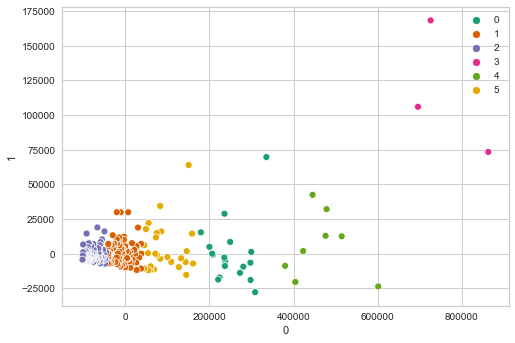

In [24]:
kmeans_cluster2 = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_cluster2.fit(cluster2)
results_evaluation_subclusters(kmeans_cluster2, cluster2, 2)

sv = SilhouetteVisualizer(kmeans_cluster1)
sv.fit(cluster1).show()

sns.scatterplot(cluster2[0], cluster2[1], hue=kmeans_cluster2.labels_,palette='Dark2')

In [25]:
subclusters2 = subclustering[subclustering['Cluster']==2].copy()
subclusters2['Subcluster'] = kmeans_cluster2.labels_
subclusters2= subclusters2.merge(groupby_domains[['Format Fill Rate']], left_index=True, right_index=True)
sub2_1, sub2_2 , sub2_3, sub2_4, sub2_5, sub2_6 = [x for _, x in subclusters2.groupby('Subcluster')] #To make easier the analysis below
subclusters2.drop('Cluster', 1).groupby('Subcluster').describe()

Format Loads                                                       \
                  count     mean     std      min      25%      50%      75%   
Subcluster                                                                     
0                  18.0 372570.7 43439.7 300034.9 344041.5 358654.6 414701.3   
1                  75.0 112699.3 22802.3  80292.9  94375.0 108772.6 128395.8   
2                 155.0  41168.2 14602.0  20347.5  29514.0  37654.3  51408.4   
3                   3.0 874187.9 90943.0 809165.1 822226.3 835287.5 906699.4   
4                   8.0 585542.4 70111.6 501339.7 539080.6 579542.6 606292.2   
5                  27.0 212409.0 39320.1 166460.3 179783.5 197119.8 251779.0   

                    Impressions                                              \
                max       count     mean     std      min      25%      50%   
Subcluster                                                                    
0          451921.3        18.0  26566.0 22481.3   2500.7  14834.3  22934.6   
1          159665.7        75.0  11617.5  8857.4    692.0   4763.0  10677.6   
2           76260.1       155.0   3983.7  4263.4      7.8   1234.6   2807.3   
3          978111.2         3.0 174513.9 44692.6 138521.2 149501.6 160481.9   
4          723142.7         8.0  46270.2 23627.1  15914.2  25820.4  46524.4   
5          282756.6        27.0  20670.1 17712.4   2317.9  10359.9  14671.4   

                             Clicks                                         \
                75%      max  count   mean    std   min   25%   50%    75%   
Subcluster                                                                   
0           30296.7 101494.8   18.0  168.4  105.4  13.8  74.9 166.5  215.0   
1           15978.1  40990.1   75.0   83.9   72.9   2.1  25.0  66.3  123.9   
2            5048.9  25461.8  155.0   28.5   38.7   0.1   6.5  19.8   31.4   
3          192510.3 224538.7    3.0 1526.8 1516.2 562.4 653.0 743.6 2009.1   
4           60044.4  81245.0    8.0  339.6  257.7 105.9 148.0 300.7  402.4   
5           30955.6  84119.3   27.0  142.0   90.5  13.8  76.5 125.7  193.6   

                  Format Fill Rate                                    
              max            count mean  std min  25%  50%  75%  max  
Subcluster                                                            
0           419.4             18.0  9.4  8.4 0.6  3.8  6.7 11.4 30.2  
1           281.6             75.0 11.7  8.5 0.5  5.0 11.1 16.6 39.7  
2           382.2            155.0  9.8  9.7 0.0  3.0  7.3 12.4 54.0  
3          3274.5              3.0 19.3 10.4 7.5 15.3 23.2 25.2 27.1  
4           895.5              8.0 13.2 12.4 3.1  5.2  8.9 15.4 39.4  
5           351.6             27.0 11.3  8.8 1.6  5.4  8.2 17.6 37.3

- **Cluster 2 subcluster 1**: 18 Domains. Format Loads between 300.000 and 450.000. It has a decent Format Fill Rate (9.50%)
- **Cluster 2 subcluster 2**:75  domains with Format loads range 80-160.000. Good Format Fill rate (11.72%)
- **Cluster 2 subcluster 3**: Main subcluster with 155 domains and the lowest Format Loads of the cluster, between 20.000 and 76.000. Format fill rate around 10%
- **Cluster 2 subcluster 4**: 3 outliers with Format loads range 809-978.000, and the highest rates of Impressions, clicks and Format Fill Rate. 
- **Cluster 2 subcluster 5**: 8  domains with Format loads range 500-723.000. Strong Format Fill Rate (13%) and high mean of clicks(339)
- **Cluster 2 subcluster 6**: 27 Domains with FL between 166.000 and 282.000 (medium range). High means of Impressions, clicks and Format Fill Rate.


### ***SUBCLUSTERING: CLUSTER 3***

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


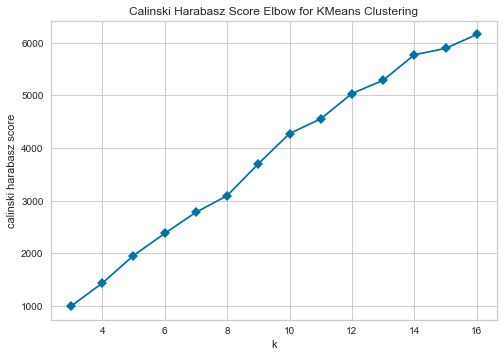

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


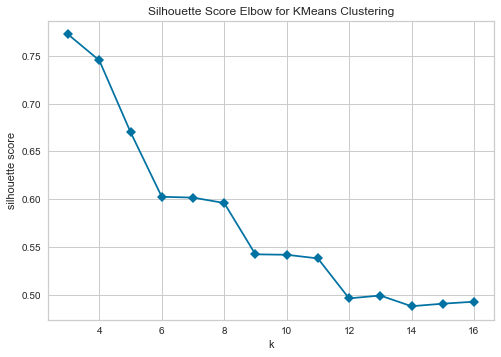

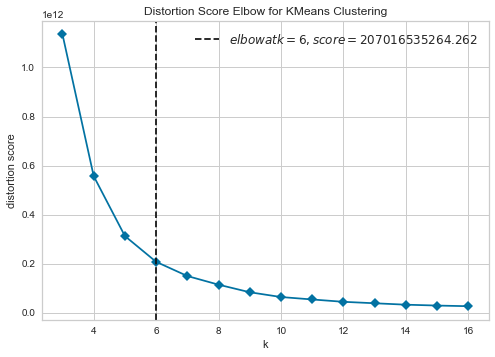

In [27]:
cluster3= new_clustering_pca[new_clustering_pca['Cluster']==3].copy()
cluster3.drop('Cluster', 1, inplace=True)
model = KMeans(init='k-means++', max_iter=1000, n_init=10, algorithm='auto')
visualization_clusters(cluster3, model)

CLUSTERING DIVISION:
 1    145
5     59
0     24
4     17
3      3
2      1
Name: 0, dtype: int64


,Format Loads,Impressions,Clicks
Cluster,,,
0,205182.3,18604.2,64.3
1,37191.9,3618.0,16.3
2,2739246.9,8942.4,46.8
3,741600.8,37467.0,244.0
4,354612.7,12400.7,59.2
5,97010.9,5711.9,23.4


The Silhouette Score is:  0.6024475960930301
The Calinski Harabasz Score is:  2378.3111046132176
The Davies Douldin Score is:  0.44931907163810586


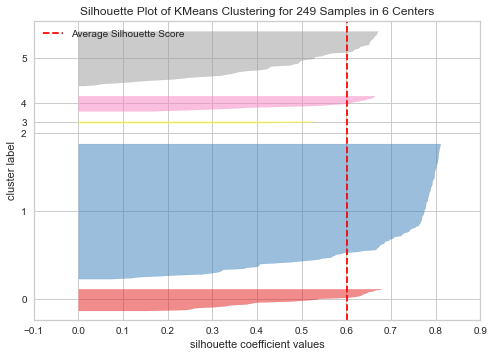

<AxesSubplot:xlabel='0', ylabel='1'>

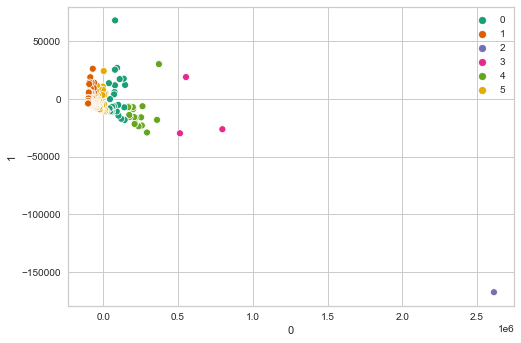

In [29]:
kmeans_cluster3 = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_cluster3.fit(cluster3)
results_evaluation_subclusters(kmeans_cluster3, cluster3, 3)

sv = SilhouetteVisualizer(kmeans_cluster3)
sv.fit(cluster3).show()

sns.scatterplot(cluster3[0], cluster3[1], hue=kmeans_cluster3.labels_,palette='Dark2')

In [30]:
subclusters3 = subclustering[subclustering['Cluster']==3].copy()
subclusters3['Subcluster'] = kmeans_cluster3.labels_
subclusters3= subclusters3.merge(groupby_domains[['Format Fill Rate']], left_index=True, right_index=True)

sub3_1, sub3_2 , sub3_3, sub3_4, sub3_5, sub3_6= [x for _, x in subclusters3.groupby('Subcluster')] #To make easier the analysis below

subclusters3.drop('Cluster', 1).groupby('Subcluster').describe()

Format Loads                                                   \
                  count      mean      std       min       25%       50%   
Subcluster                                                                 
0                  24.0  205182.3  34025.5  157940.6  178545.0  196562.9   
1                 145.0   37191.9  13166.6   20168.3   25393.7   34708.4   
2                   1.0 2739246.9      nan 2739246.9 2739246.9 2739246.9   
3                   3.0  741600.8 153709.1  634961.6  653505.0  672048.4   
4                  17.0  354612.7  60848.3  288315.0  318776.8  334065.4   
5                  59.0   97010.9  22398.1   67714.2   77202.7   95723.5   

                               Impressions                                  \
                 75%       max       count    mean     std     min     25%   
Subcluster                                                                   
0           224836.3  266097.2        24.0 18604.2 19387.8  1018.2  4288.8   
1            47620.1   65981.9       145.0  3618.0  5153.8     0.0   538.9   
2          2739246.9 2739246.9         1.0  8942.4     nan  8942.4  8942.4   
3           794920.5  917792.5         3.0 37467.0 25631.3 13314.5 24021.9   
4           379777.8  490576.4        17.0 12400.7 14578.8    64.0  3858.9   
5           115807.7  146129.8        59.0  5711.9  6759.3     1.0  1048.3   

                                   Clicks                                      \
               50%     75%     max  count  mean   std   min   25%   50%   75%   
Subcluster                                                                      
0          11956.8 28381.0 83235.6   24.0  64.3  80.0   0.1   8.6  27.9  90.8   
1           1886.4  4391.3 32114.9  145.0  16.3  30.6   0.0   1.4   6.5  16.4   
2           8942.4  8942.4  8942.4    1.0  46.8   nan  46.8  46.8  46.8  46.8   
3          34729.3 49543.3 64357.3    3.0 244.0 107.3 141.2 188.3 235.3 295.3   
4           8030.1 14771.8 64051.6   17.0  59.2  79.1   0.0   6.8  25.8  59.7   
5           3615.2  7766.2 34750.9   59.0  23.4  36.4   0.0   2.3  10.2  21.7   

                 Format Fill Rate                                  
             max            count mean  std min 25% 50%  75%  max  
Subcluster                                                         
0          310.9             24.0  8.8 10.3 0.2 2.3 4.6 11.4 41.4  
1          205.1            145.0  8.8 12.2 0.0 1.8 4.7 10.4 85.3  
2           46.8              1.0  0.6  nan 0.6 0.6 0.6  0.6  0.6  
3          355.3              3.0  9.7  7.5 2.2 6.0 9.8 13.5 17.2  
4          309.3             17.0  5.1  5.0 0.0 0.9 3.8  6.7 16.9  
5          196.8             59.0  6.9  7.4 0.0 1.6 3.8  9.6 29.3

- **Cluster 3 subcluster 1**: 24 Domains. Format Loads between 157.000 and 266.000(medium range). It has a decent Format Fill Rate (8.80%)
- **Cluster 3 subcluster 2**:Main subcluster with 145 domains and the lowest Format Loads of the cluster, between 20.000 and 65.000. Format fill rate around 9%
- **Cluster 3 subcluster 3**: 1 outlier, the one with the highest traffic of the dataset (2.700.000) but the worst Format Fill Rate of the cluster (0,6%)
- **Cluster 3 subcluster 4**: 3 outliers (FL between 634-917.000), the best Clicks mean  and the best Format Fill Rate of the cluster (9.73)
- **Cluster 3 subcluster 5**: 17 Domains with FL between 288.000 and 490.000. Poor Format Fill Rate (5%)
- **Cluster 3 subcluster 6**: 59 Domains. Format Loads range: 67-146.000. Poor FL rate (6%) 


### SUBCLUSTERING: CLUSTER 4

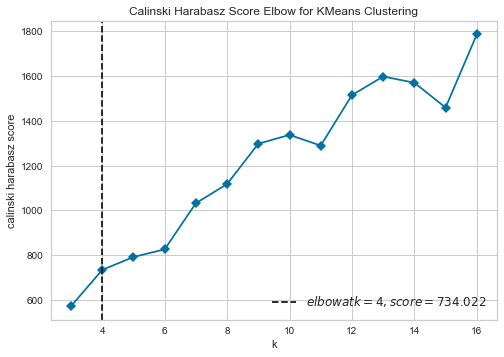

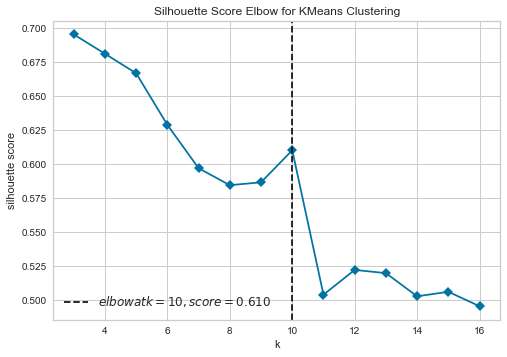

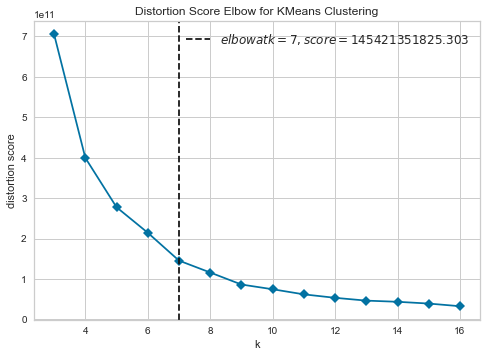

In [33]:
cluster4= new_clustering_pca[new_clustering_pca['Cluster']==4].copy()
cluster4.drop('Cluster', 1, inplace=True)
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(cluster4, model)

CLUSTERING DIVISION:
 0    143
3     38
2      8
1      5
Name: 0, dtype: int64


,Format Loads,Impressions,Clicks
Cluster,,,
0,48948.3,6107.5,36.8
1,854213.6,38233.3,127.7
2,461873.2,87167.7,355.6
3,179918.5,22157.4,150.0


The Silhouette Score is:  0.6813253813225585
The Calinski Harabasz Score is:  734.0222881633666
The Davies Douldin Score is:  0.5517746759169275


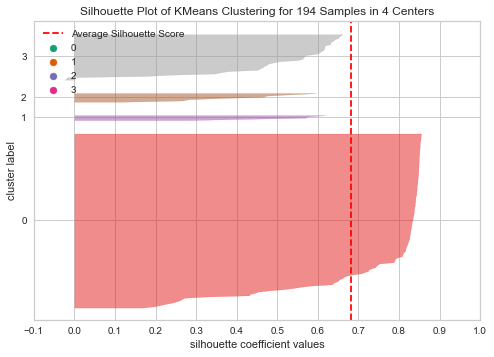

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 194 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [39]:
kmeans_cluster4 = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=15, algorithm='auto')
kmeans_cluster4.fit(cluster4)
results_evaluation_subclusters(kmeans_cluster4, cluster4, 4)

sns.scatterplot(cluster4[0], cluster4[1], hue=kmeans_cluster4.labels_,palette='Dark2')

sv = SilhouetteVisualizer(kmeans_cluster4)
sv.fit(cluster4).show()

In [40]:
subclusters4 = subclustering[subclustering['Cluster']==4].copy()
subclusters4['Subcluster'] = kmeans_cluster4.labels_
subclusters4= subclusters4.merge(groupby_domains[['Format Fill Rate']], left_index=True, right_index=True)


sub4_1, sub4_2, sub4_3, sub4_4 = [x for _, x in subclusters4.groupby('Subcluster')]

subclusters4.drop('Cluster', 1).groupby('Subcluster').describe()

Format Loads                                                        \
                  count     mean      std      min      25%      50%      75%   
Subcluster                                                                      
0                 143.0  48948.3  25126.9  20381.4  28278.8  41357.7  65772.3   
1                   5.0 854213.6 150656.8 708477.2 742033.7 796087.9 969535.3   
2                   8.0 461873.2  97407.5 351715.6 391502.5 433201.0 531641.0   
3                  38.0 179918.5  48414.3 113082.2 144609.5 165616.9 209300.7   

                     Impressions                                          \
                 max       count    mean     std     min     25%     50%   
Subcluster                                                                 
0           109875.7       143.0  6107.5  6746.1     3.6  1623.1  3946.4   
1          1054934.0         5.0 38233.3 30368.1     9.7 22824.3 34032.1   
2           606538.2         8.0 87167.7 63225.3 34175.0 37173.3 53112.6   
3           314675.3        38.0 22157.4 22978.7  1704.5  9175.7 13825.7   

                             Clicks                                            \
                75%      max  count  mean   std   min   25%   50%   75%   max   
Subcluster                                                                      
0            8406.4  37652.5  143.0  36.8  44.4   0.0   9.1  20.9  49.4 268.3   
1           54895.6  79405.1    5.0 127.7 137.2   0.0   9.7 145.1 145.3 338.6   
2          142635.4 183288.7    8.0 355.6 202.5 165.5 211.3 268.0 465.3 685.8   
3           26429.0 126908.9   38.0 150.0 145.1   0.3  65.2 109.3 193.7 657.4   

           Format Fill Rate                                   
                      count mean  std min 25%  50%  75%  max  
Subcluster                                                    
0                     143.0 11.6  9.4 0.0 4.3  9.3 18.8 51.8  
1                       5.0  5.6  5.5 0.0 1.9  3.8  9.0 13.3  
2                       8.0 20.2 16.6 5.9 8.8  9.7 34.9 47.9  
3                      38.0 14.4 12.7 1.0 5.6 11.0 19.2 67.9

- **Cluster 4 subcluster 1**: Main subcluster with 143 domains and the lowest Format Loads of the cluster, between 20.000 and 110.000. Format fill rate around 11%
- **Cluster 4 subcluster 2**: 5 outliers, between 700-1.000.000 FL, and lowest FL rate mean of the cluster (5%)
- **Cluster 4 subcluster 3**: 8 Domains (FL between 350-600.000), the best Clicks mean  and the best Format Fill Rate of the cluster by far(20%)
- **Cluster 4 subcluster 4**: 38 Domains. Format Loads range: 110-315.000. Good FL rate (14%) 



        

### ***Some observations about the subclustering proccess***

- In the four clusters we have a big subcluster which contains the  domains the worst quality of the cluster (low Format Loads, Impressions and Clicks).

- We can observe that the most decisive variable is Format Loads. The algorithm divide the clusters by Format Loads ranges, and Impressions and Clicks come into play when the Format Loads ranges are similar. Theorically, this could be a disadvantage because Format Loads have too much weight. But in this case, looking from a business point of view, it´s just what I need because that is the most important variable by far.

- In the four clusters, the number of subclusters with better results, attending to the internal validation, was 4. However, I tried with 4 and 6 suclusters, and I finally decided to choose 6 and sacrified the best tecnhical results for one reason: I observed, because of the proximity of points, that when I reduced the subclusters, the domains are recolocated in the main subcluster, which is the one that I clearly want to separate from the rest, because it contains the bad quality domains, and this helps to make a better division. *I did an exception in cluster 4 because the results with 6 clusters were worse than in the other clusters*

In [45]:
concat_subclusters = pd.concat([sub1_1, sub1_2 , sub1_3, sub1_4, sub1_5, sub1_6,
    sub2_1, sub2_2 , sub2_3, sub2_4, sub2_5, sub2_6,
    sub3_1, sub3_2 , sub3_3, sub3_4, sub3_5, sub3_6,
    sub4_1, sub4_2, sub4_3, sub4_4])

#merging subclusters with the main dataframe by the index
domains_final_clustering = concat_subclusters[['Cluster', 'Subcluster']].merge(groupby_domains, left_index=True, 
                                                                               right_index=True).reset_index(drop=True)
domains_final_clustering['Subcluster'] = domains_final_clustering['Subcluster'] + 1 #to avoid the subclusters 0

cluster1_global = domains_final_clustering[domains_final_clustering['Cluster']==1]
cluster2_global = domains_final_clustering[domains_final_clustering['Cluster']==2]
cluster3_global = domains_final_clustering[domains_final_clustering['Cluster']==3]
cluster4_global = domains_final_clustering[domains_final_clustering['Cluster']==4]


domains_final_clustering.to_csv('DATA/Domains clustered.csv', index=False)
cluster1_global.to_csv('DATA/Global Cluster 1.csv', index=False)
cluster2_global.to_csv('DATA/Global Cluster 2.csv', index=False)
cluster3_global.to_csv('DATA/Global Cluster 3.csv', index=False)
cluster4_global.to_csv('DATA/Global Cluster 4.csv', index=False)

In [47]:
domains_final_clustering.groupby(['Cluster','Subcluster']).agg({'Format Loads':np.mean,
                                                                'Impressions':np.mean,
                                                                'Format Fill Rate':np.mean,
                                                                'Clicks':np.mean,
                                                                'CTR':np.mean,
                                                                'CPM':np.mean,
                                                                'Efficiency Rate':np.mean,
                                                                'Viewability Rate':np.mean,
                                                                'Domain':['count']
                                                                })

Format Loads Impressions Format Fill Rate Clicks  CTR  CPM  \
                           mean        mean             mean   mean mean mean   
Cluster Subcluster                                                              
1       1               43021.6      5381.1             11.6   24.7  0.5  1.4   
        2              935071.7     77104.9             10.0  459.9  0.5  1.7   
        3              318721.9     28079.1             12.3  196.7  0.7  1.5   
        4             1732798.1    124798.8             10.8   98.4  0.1  1.7   
        5              136565.3      8579.5              7.4   53.3  0.5  1.5   
        6              609388.5     28897.5              6.2  287.7  0.5  1.5   
2       1              372570.7     26566.0              9.4  168.4  0.7  1.7   
        2              112699.3     11617.5             11.7   83.9  0.7  1.6   
        3               41168.2      3983.7              9.8   28.5  0.7  1.5   
        4              874187.9    174513.9             19.3 1526.8  0.8  1.4   
        5              585542.4     46270.2             13.2  339.6  0.8  1.6   
        6              212409.0     20670.1             11.3  142.0  0.8  1.6   
3       1              205182.3     18604.2              8.8   64.3  0.3  1.5   
        2               37191.9      3618.0              8.8   16.3  0.4  1.4   
        3             2739246.9      8942.4              0.6   46.8  0.5  1.6   
        4              741600.8     37467.0              9.7  244.0  0.7  1.7   
        5              354612.7     12400.7              5.1   59.2  0.3  1.5   
        6               97010.9      5711.9              6.9   23.4  0.4  1.4   
4       1               48948.3      6107.5             11.6   36.8  0.5  1.4   
        2              854213.6     38233.3              5.6  127.7  0.4  1.7   
        3              461873.2     87167.7             20.2  355.6  0.6  1.7   
        4              179918.5     22157.4             14.4  150.0  0.7  1.6   

                   Efficiency Rate Viewability Rate Domain  
                              mean             mean  count  
Cluster Subcluster                                          
1       1                     82.4             72.1     96  
        2                     93.8             76.3      4  
        3                     86.0             75.2     16  
        4                     98.5             78.1      1  
        5                     84.5             73.5     47  
        6                     87.7             71.2      8  
2       1                     92.3             82.8     18  
        2                     91.7             81.3     75  
        3                     83.9             76.9    155  
        4                     83.4             68.2      3  
        5                     94.3             80.7      8  
        6                     90.8             80.5     27  
3       1                     83.3             72.7     24  
        2                     76.2             64.4    145  
        3                     92.7             83.8      1  
        4                     91.1             75.1      3  
        5                     85.3             71.7     17  
        6                     81.7             70.0     59  
4       1                     81.8             70.4    143  
        2                     78.1             74.8      5  
        3                     97.6             80.8      8  
        4                     91.3             78.5     38

### **Interactive visualization of the subclusters through Tableau is available in this [link](https://github.com/rfisla/FINAL-PROJECT-OF-KSCHOOL-MASTER/blob/master/Graphs/SUBCLUSTERS%20VISUALIZATION.twbx)**

### **The final step will be to use Streamlit to make a final presentation of the results through a user interactive app**

#### I don´t need the Category importance and Geographical zone importance columns anymore, so I´ll delete them
#### I´ll also round the dataframes to make them more readable

In [49]:
domains_final_clustering.drop(['Category importance', 'Geographical zone importance'], 1, inplace=True)
cluster1_global.drop(['Category importance', 'Geographical zone importance'], 1, inplace=True)
cluster2_global.drop(['Category importance', 'Geographical zone importance'], 1, inplace=True)
cluster3_global.drop(['Category importance', 'Geographical zone importance'], 1, inplace=True)
cluster4_global.drop(['Category importance', 'Geographical zone importance'], 1, inplace=True)

domains_final_clustering = domains_final_clustering.round(2)
cluster1_global = cluster1_global.round(2)
cluster2_global = cluster2_global.round(2)
cluster3_global = cluster3_global.round(2)
cluster4_global = cluster4_global.round(2)

domains_final_clustering.to_csv('DATA/Domains clustered.csv', index=False)
cluster1_global.to_csv('DATA/Global Cluster 1.csv', index=False)
cluster2_global.to_csv('DATA/Global Cluster 2.csv', index=False)
cluster3_global.to_csv('DATA/Global Cluster 3.csv', index=False)
cluster4_global.to_csv('DATA/Global Cluster 4.csv', index=False)

domains_final_clustering.head(5)

,Cluster,Subcluster,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,Category,Country,Geographical zone
0,1,1,inforuss.info,85713.2,65.7,0.1,96.3,99.5,1.6,0.5,0.6,News & Portals,Russia,East Europe
1,1,1,newindianexpress.com,80994.9,3042.0,8.9,77.2,89.0,1.6,10.4,0.3,News & Portals,United Kingdom,West Europe
2,1,1,eldigitalcastillalamancha.es,80706.2,20194.6,20.6,82.5,89.7,1.6,151.5,0.6,News & Portals,Spain,West Europe
3,1,1,stirilekanald.ro,80331.8,4633.2,6.1,89.7,89.4,1.6,22.2,0.5,News & Portals,Romania,East Europe
4,1,1,etnet.com.hk,79272.2,13759.7,18.5,70.7,95.4,1.7,23.5,0.2,News & Portals,Hong Kong,Asia
